<a href="https://colab.research.google.com/github/rodolfocustodio/transfer-learning/blob/main/train_net_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#net YOLO - transfer learning


Instalar o ultralytics se não encontrar.

In [3]:
!pip install ultralytics
!pip install fiftyone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.5/934.5 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:0

In [4]:
import ultralytics
print(f"Ultralytics version: {ultralytics.__version__}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version: 8.4.7


In [48]:
from ultralytics import YOLO

# Carrega um modelo pré-treinado (yolov8n.pt) que será baixado automaticamente se não estiver presente
model = YOLO('yolov8n.pt')

print("Modelo YOLOv8n baixado e carregado com sucesso.")

Modelo YOLOv8n baixado e carregado com sucesso.


In [ ]:
import fiftyone as fo
import fiftyone.utils.yolo as fouy
import os
import shutil

# Define o diretório de exportação
export_dir = "/content/yolo_fiftyone_dataset"

# Remove o diretório de exportação existente para garantir uma exportação limpa
if os.path.exists(export_dir):
    shutil.rmtree(export_dir)
    print(f"Removed existing directory: {export_dir}")
os.makedirs(export_dir, exist_ok=True)

# Define dataset names
train_dataset_name = "coco-2017-train-50-for-yolo"
val_dataset_name = "coco-2017-validation-50-for-yolo"

# Deleta dataset existente
if fo.dataset_exists(train_dataset_name):
    fo.delete_dataset(train_dataset_name)
    print(f"Deleted existing FiftyOne dataset: {train_dataset_name}")

if fo.dataset_exists(val_dataset_name):
    fo.delete_dataset(val_dataset_name)
    print(f"Deleted existing FiftyOne dataset: {val_dataset_name}")

# Carrega o dataset de treino com as classes especificadas
print("Loading train dataset...")
train_dataset = fo.zoo.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=["clock", "suitcase", "bird"],
    max_samples=50,
    dataset_name=train_dataset_name
)

for sample in train_dataset.iter_samples(autosave=True):
    if "detections" not in sample:
        sample["detections"] = fo.Detections()
    sample.save()

# Carrega o dataset de validação com as classes especificadas
print("Loading validation dataset...")
val_dataset = fo.zoo.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["clock", "suitcase", "bird"],
    max_samples=50,
    dataset_name=val_dataset_name
)

for sample in val_dataset.iter_samples(autosave=True):
    if "detections" not in sample:
        sample["detections"] = fo.Detections()
    sample.save()

# Exporta o dataset de treino para a estrutura YOLOv5/YOLOv8
print("Exporting train dataset...")
train_dataset.export(
    export_dir=os.path.join(export_dir, "train"),
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="detections",
)

# Exporta o dataset de validação para a estrutura YOLOv5
print("Exporting validation dataset...")
val_dataset.export(
    export_dir=os.path.join(export_dir, "val"),
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="detections",
)

# Cria o arquivo dataset.yaml necessário pelo Ultralytics YOLOv8
yaml_content = f"""
path: {export_dir} # caminho raiz do dataset
train: train/images # imagens de treino (relativo ao 'path')
val: val/images # imagens de validação (relativo ao 'path')
test:  # conjunto de teste opcional, descomente e adicione o caminho se disponível

nc: 3
names: ["clock", "suitcase", "bird"]
"""

dataset_yaml_path = os.path.join(export_dir, "dataset.yaml")
with open(dataset_yaml_path, "w") as f:
    f.write(yaml_content)

print(f"Dataset exportado para: {export_dir}")
print(f"Custom dataset.yaml criado em: {dataset_yaml_path}")
print("Content of dataset.yaml:")
with open(dataset_yaml_path, 'r') as f:
    print(f.read())

In [65]:
!ls -lh runs/detect/predict/


total 708K
-rw-r--r-- 1 root root 706K Jan 27 16:41 passaros_relogio.jpg


In [ ]:
print("Configurando e iniciando o treinamento do modelo...")

# Define os parâmetros de treinamento para fine-tuning
# Sugestões para fine-tuning:
# epochs: Geralmente menor para fine-tuning (e.g., 10-50)
# batch: Pode variar dependendo da GPU (e.g., 16, 32)
# imgsz: Tamanho da imagem de entrada (e.g., 640)
# lr0: Taxa de aprendizado inicial, frequentemente menor que o padrão para pré-treinamento

# Exemplo de configuração de treinamento (estes valores podem ser ajustados conforme o dataset e hardware)
# O parâmetro 'data' agora aponta para o arquivo data.yaml gerado pelo FiftyOne
# Certifique-se de que a célula que carrega o modelo YOLO ('model = YOLO(...)') tenha sido executada antes desta.
results = model.train(data="/content/yolo_fiftyone_dataset/dataset.yaml", epochs=10, batch=16, imgsz=640, lr0=0.001)
#

print("Treinamento concluído. Resultados salvos em 'runs/detect/train' (ou similar).")

In [ ]:
results = model.predict(source="/content/passaros_relogio.jpg", save=True)



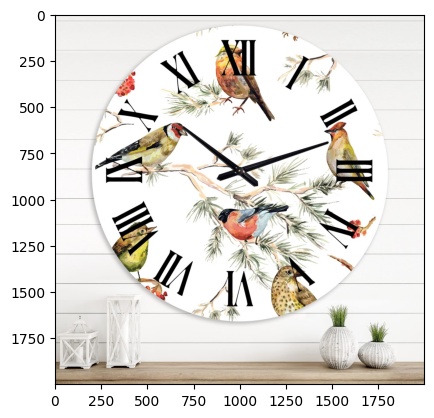

In [69]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = '/content/runs/detect/predict/passaros_relogio.jpg'
image = Image.open(img_path)

# Display the image
plt.imshow(image)
plt.show()
